# Polyp Segmentation Model using UNet and PSPNet

Author - Mahesh Raut

The project represents a comprehensive pipeline for the development and evaluation of polyp segmentation models utilizing the UNet and PSPNet architectures. This project encompasses various stages, commencing with the preparation of the dataset—comprising image and mask pairs—followed by a division into training and validation subsets. The subsequent step involves loading and augmenting the data using custom methods, ensuring variability and robustness during model training.

The approach lies in the creation of the segmentation models themselves. Both UNet and PSPNet architectures are harnessed for their distinct advantages in capturing features and contextual information. Pretrained encoders, along with tailored activation functions, infuse the models with domain knowledge. During training, hyperparameters are fine-tuned, loss functions are configured, and optimizers are applied to enhance model performance. Metrics such as IoU score and Dice Loss are computed to evaluate the segmentation quality. The entire process is executed over a defined number of epochs, with periodic validation to monitor progress.

Following model training, the framework transitions to evaluation, where the models' effectiveness is measured on the validation dataset. Metrics, including IoU score, Dice Loss, and Dice Score, are quantified to provide insights into segmentation accuracy. Importantly, the PSPNet architecture is also introduced as an alternative approach to the UNet, broadening the scope of model comparison. The pipeline underscores the interplay between data manipulation, model architecture, and performance evaluation, ultimately contributing to the advancement of polyp segmentation methodologies.

Intructions:
- Upload kvasir-seg.zip to the path "/content/".
- Also, "unet_model.pth" and "pspnet_model.pth" to directly run sections "UNet Model Inference on Validation Set" and "PSPNet Model Inference on Validation Set". Upload both the models to the same path "/content/"


In [ ]:
# Import Libraires
import zipfile
import cv2
import tqdm, os
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import albumentations as album
import warnings
warnings.filterwarnings("ignore")
from torch.utils.data import DataLoader
import seaborn as sns
import numpy as np

# Kvasir-SEG Dataset Preprocessing

In [ ]:
# Path to the kvasir_seg zip file
kvasir_seg = 'kvasir-seg.zip'

# Open the kvasir_seg zip file
with zipfile.ZipFile(kvasir_seg, 'r') as zip_ref:
    # Extract all contents
    zip_ref.extractall()

print("Extraction of kvasir-seg.zip complete.")

Extraction of kvasir-seg.zip complete.


In [ ]:
# Configure directories for data
DATA_DIR = '/content/Kvasir-SEG/'
IMAGES_SUBDIR = os.path.join(DATA_DIR, 'images')
MASKS_SUBDIR = os.path.join(DATA_DIR, 'masks')

# Catalog files in image and mask directories
img_files = os.listdir(IMAGES_SUBDIR)
msk_files = os.listdir(MASKS_SUBDIR)

# Identify image identifiers from filenames (assuming .jpg extensions)
img_ids = [f for f in img_files]

# Compile data into a dictionary
data_dict = {
    'img_id': img_ids,
    'img_path': [os.path.join(IMAGES_SUBDIR, f) for f in img_files],
    'msk_path': [os.path.join(MASKS_SUBDIR, f) for f in msk_files]
}

# Generate a DataFrame from the collected data
data = pd.DataFrame(data_dict)

# Rearrange DataFrame columns
data = data[['img_id', 'img_path', 'msk_path']]

# Display the initial entries in the DataFrame
print("Head of data : ")
data.head()


Head of data : 


,img_id,img_path,msk_path
0,cju1fm3id6gl50801r3fok20c.jpg,/content/Kvasir-SEG/images/cju1fm3id6gl50801r3...,/content/Kvasir-SEG/masks/cju1fm3id6gl50801r3f...
1,cju5vi4nxlc530817uoqm2m7a.jpg,/content/Kvasir-SEG/images/cju5vi4nxlc530817uo...,/content/Kvasir-SEG/masks/cju5vi4nxlc530817uoq...
2,cju17g6ykn1cs0993dww6qdi8.jpg,/content/Kvasir-SEG/images/cju17g6ykn1cs0993dw...,/content/Kvasir-SEG/masks/cju17g6ykn1cs0993dww...
3,cju5bdwa3aatx0818b79i18zf.jpg,/content/Kvasir-SEG/images/cju5bdwa3aatx0818b7...,/content/Kvasir-SEG/masks/cju5bdwa3aatx0818b79...
4,cju1hs0za7jha0855vj0mdrjt.jpg,/content/Kvasir-SEG/images/cju1hs0za7jha0855vj...,/content/Kvasir-SEG/masks/cju1hs0za7jha0855vj0...


# Train-Val Split

In [ ]:
# Randomly shuffle the DataFrame
data_df = data.sample(frac=1).reset_index(drop=True)

# Divide the data into training and validation sets (90/10 split)
val_data_df = data_df.sample(frac=0.1, random_state=42)
train_data_df = data_df.drop(val_data_df.index)

# Define class names and their corresponding RGB values
label_classes = ['polyp', 'background']
label_rgb_codes = [[255, 255, 255], [0, 0, 0]]

# If needed, filter specific classes from the larger dataset
filtered_classes = ['polyp', 'background']

# Extract RGB values for the desired classes
filtered_class_indices = [label_classes.index(lbl.lower()) for lbl in filtered_classes]
filtered_class_rgb = np.array(label_rgb_codes)[filtered_class_indices]

# Display the lengths of training and validation sets
train_set_len, val_set_len = len(train_data_df), len(val_data_df)
print("Train Set Length, Val Set Length :: ")
train_set_len, val_set_len


Train Set Length, Val Set Length :: 


(900, 100)

# Data Visualization

    """
    one_hot_encode(label, values)
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """

In [ ]:
# Perform one hot encoding on label
def one_hot_encode(label, values):
    map = []
    for colour in values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        map.append(class_map)
    map = np.stack(map, axis=-1)

    return map

    """
    reverse_one_hot(img)
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        img: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """

In [ ]:
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(img):
    dx = np.argmax(img, axis = -1)
    return dx

    """
    segmentation_color(image, values):
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        values

    # Returns
        Colour coded image for segmentation visualization
    """

In [ ]:
# Perform colour coding on the reverse-one-hot outputs
def segmentation_color(image, values):

    colour_codes = np.array(values)
    dx = colour_codes[image.astype(int)]

    return dx

In [ ]:
# Plot images in one row
def show(**imgs):
    total_images = len(imgs)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(imgs.items()):
        plt.subplot(1, total_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()



Kvasir-SEG Data Processing: Image Reading, Augmentation, and Preprocessing

This module facilitates the handling of the Kvasir-SEG dataset. It involves the reading of images, application of augmentation, and preprocessing transformations.

Parameters:
    - df (DataFrame): A DataFrame containing paths to images and corresponding labels.
    - class_rgb_values (list): RGB values assigned to specific classes for extraction from segmentation masks.
    - augmentation (albumentations.Compose): A composed data transformation pipeline, which may include operations such as flipping, scaling, and more.
    - preprocessing (albumentations.Compose): A composed data preprocessing pipeline, which may involve normalization, shape manipulation, and other preprocessing steps.

This module streamlines the process of preparing data from the Kvasir-SEG dataset for further use in training or evaluation of machine learning models. By providing options for augmentation and preprocessing, it offers flexibility in customizing data transformations to enhance model performance.



In [ ]:
class Kvasir(torch.utils.data.Dataset):

    def __init__(
            self,
            df,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.image_paths = df['img_path'].tolist()
        self.mask_paths = df['msk_path'].tolist()

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

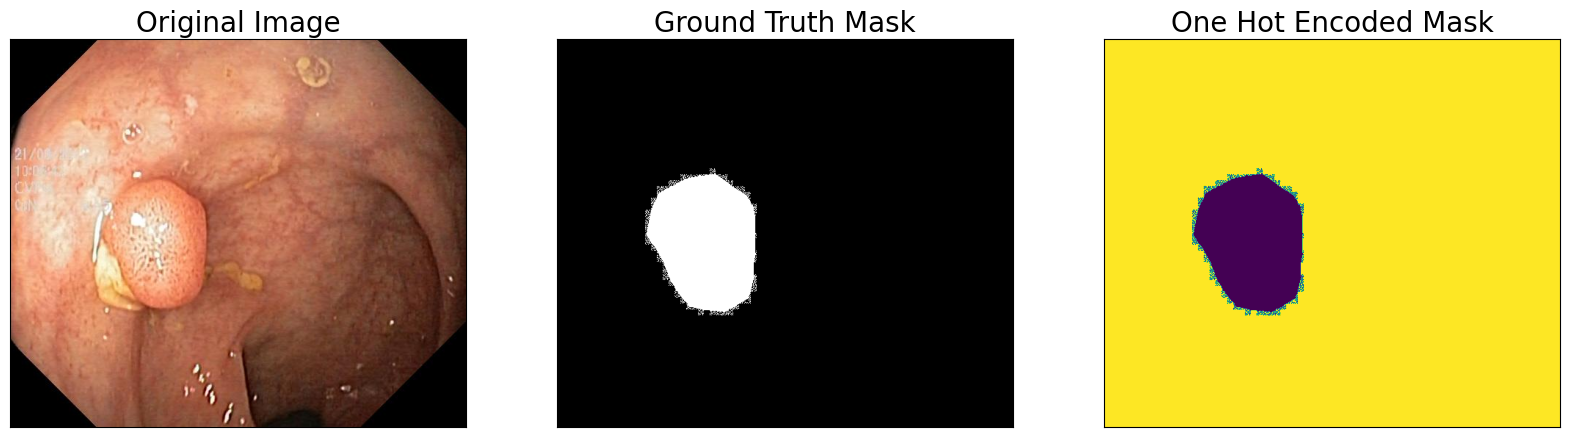

In [ ]:
dataset = Kvasir(train_data_df, class_rgb_values=filtered_class_rgb)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[0]

show(
    original_image = image,
    ground_truth_mask = segmentation_color(reverse_one_hot(mask), filtered_class_rgb),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Enhancing Data Variability: Augmentation Strategies

The provided functions prepare data augmentations and preprocessing transformations for training and validation on the Kvasir-SEG dataset. These functions enable data variability through resizing, flipping, and padding, and facilitate data normalization and conversion to tensor format. They enhance the adaptability of the dataset for training neural networks, contributing to improved model performance and accuracy.

In [ ]:
def prepare_augmentations_for_training():
    training_transforms = [
        album.Resize(height=512, width=608, interpolation=cv2.INTER_CUBIC, always_apply=True),
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(training_transforms)


def prepare_augmentations_for_validation():
    # Apply ample padding to ensure image dimensions are divisible by 32
    validation_transforms = [
        album.Resize(height=512, width=608, interpolation=cv2.INTER_CUBIC, always_apply=True),
    ]
    return album.Compose(validation_transforms)


def convert_to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def prepare_preprocessing(preprocessing_function=None):
    """Construct a preprocessing transformation
    Args:
        preprocessing_function (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transformation: albumentations.Compose
    """
    _transformation = []
    if preprocessing_function:
        _transformation.append(album.Lambda(image=preprocessing_function))
    _transformation.append(album.Lambda(image=convert_to_tensor, mask=convert_to_tensor))

    return album.Compose(_transformation)


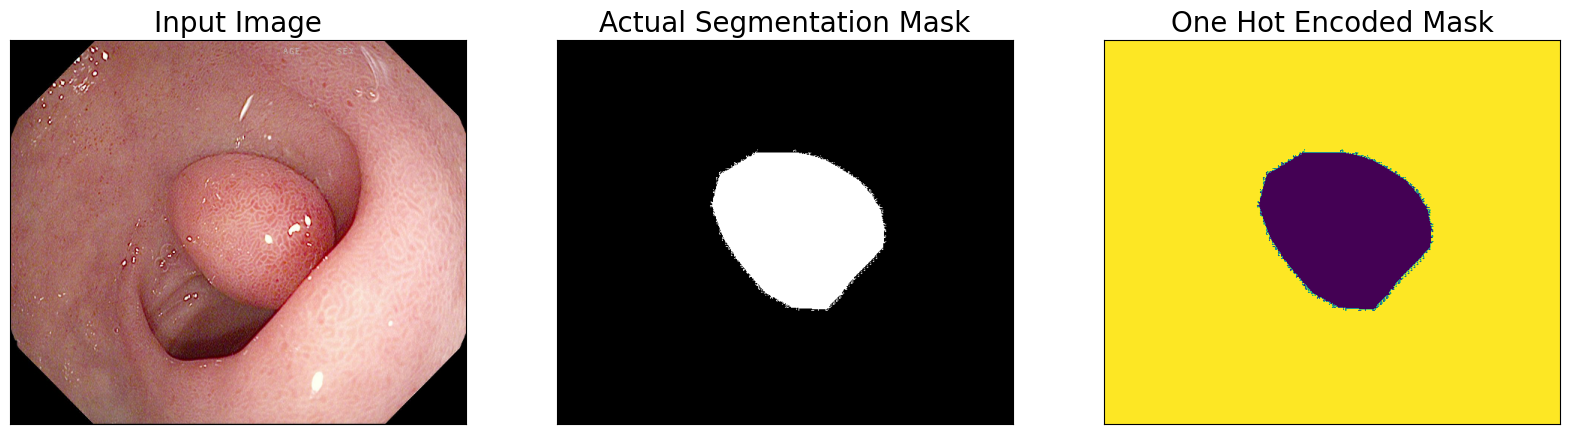

In [ ]:
# Create an augmented dataset using defined transformations
enhanced_data = Kvasir(
    train_data_df,
    augmentation=prepare_augmentations_for_training(),
    class_rgb_values=filtered_class_rgb,
)

# Generate a random index within the dataset size
random_index = random.randint(0, len(enhanced_data)-1)

# Apply different augmentations to image/mask pairs
for iteration in range(1):
    image, mask = enhanced_data[random_index]
    show(
        input_image = image,
        actual_segmentation_mask = segmentation_color(reverse_one_hot(mask), filtered_class_rgb),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )


# UNet Model

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

Define a segmentation model using a pre-trained encoder (resnet50) and imagenet weights. The model is created to perform image segmentation on a given number of classes (label_classes) with a specified activation function (sigmoid). Additionally, a preprocessing function is obtained from the segmentation model's library to prepare input data for the encoder.

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = label_classes
ACTIVATION = 'sigmoid'

# create segmentation unet model with pretrained encoder
unet_model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]


Create training and validation datasets from the Kvasir dataset using defined augmentations and preprocessing. Utilize the DataLoader to obtain batches of data for both training and validation, with specified batch sizes, shuffling, and parallel data loading.

In [ ]:
# Get train and valid dataset instances
train_dataset = Kvasir(
    train_data_df,
    augmentation=prepare_augmentations_for_training(),
    preprocessing=prepare_preprocessing(preprocessing_fn),
    class_rgb_values=filtered_class_rgb,
)

valid_dataset = Kvasir(
    val_data_df,
    augmentation=prepare_augmentations_for_validation(),
    preprocessing=prepare_preprocessing(preprocessing_fn),
    class_rgb_values=filtered_class_rgb,
)

# Get train and valid data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)

Import necessary utility modules from the segmentation_models_pytorch package. The device (DEVICE) is set based on the availability of GPU (cuda) or CPU (cpu). The loss function is defined as the Dice Loss. Evaluation metrics, including Intersection over Union (IoU) with a threshold of 0.5, are specified.

An Adam optimizer is configured with a learning rate of 0.0001. Additionally, a learning rate scheduler of type CosineAnnealingWarmRestarts is set, although it is not used in this context.

Two epoch instances are defined: train_epoch for training set operations and valid_epoch for validation set operations. These instances encapsulate the necessary logic for training and validation, including loss calculation, metric computation, optimization, and device assignment. Progress information is displayed during the process.

This configuration and setup are integral components for training and validating a segmentation model, aiding in the optimization of the model's performance and accuracy.

In [ ]:
import segmentation_models_pytorch.utils.metrics

# Set num of epochs
EPOCHS = 5
# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# define loss function
loss = smp.utils.losses.DiceLoss()
# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(),
]
# define optimizer
optimizer_unet = torch.optim.Adam([
    dict(params=unet_model.parameters(), lr=0.0001),
])
# define learning rate scheduler UNet
lr_scheduler_unet = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_unet, T_0=1, T_mult=2, eta_min=5e-5,
)

# Train Set Epoch
train_epoch_unet = smp.utils.train.TrainEpoch(
    unet_model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer_unet,
    device=DEVICE,
    verbose=True,
)

# Valid Set Epoch
valid_epoch_unet = smp.utils.train.ValidEpoch(
    unet_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

Iterating through a specified number of epochs (EPOCHS), training and validation operations are executed. During each epoch, training and validation logs are collected and appended to corresponding lists. If the validation IoU score surpasses the previous best score (iou_score), the model is saved as /content/model/unet_model.pth, ensuring consistent storage of improved model versions throughout the training process.

In [ ]:
train_logs_list_Unet, valid_logs_list_Unet = [], []
iou_score = 0.0

for i in range(0, EPOCHS):
    # Perform training & validation
    print('\nEpoch: {}'.format(i))
    train_logs_unet = train_epoch_unet.run(train_loader)
    valid_logs_unet = valid_epoch_unet.run(valid_loader)
    train_logs_list_Unet.append(train_logs_unet)
    valid_logs_list_Unet.append(valid_logs_unet)
    torch.save(unet_model, '/content/unet_model.pth')
    print('Model saved!')


Epoch: 0
valid: 100%|██████████| 25/25 [00:05<00:00,  4.25it/s, dice_loss - 0.124, iou_score - 0.8719, fscore - 0.9308]
Model saved!

Epoch: 1
valid: 100%|██████████| 25/25 [00:06<00:00,  3.76it/s, dice_loss - 0.1039, iou_score - 0.8635, fscore - 0.9252]
Model saved!

Epoch: 2
valid: 100%|██████████| 25/25 [00:06<00:00,  3.67it/s, dice_loss - 0.07714, iou_score - 0.8895, fscore - 0.9409]
Model saved!

Epoch: 3
valid: 100%|██████████| 25/25 [00:07<00:00,  3.42it/s, dice_loss - 0.0676, iou_score - 0.8958, fscore - 0.9445]
Model saved!

Epoch: 4
valid: 100%|██████████| 25/25 [00:07<00:00,  3.34it/s, dice_loss - 0.07053, iou_score - 0.884, fscore - 0.9374]
Model saved!


## UNet Model Inference on Validation Set

Load a pre-trained UNet model from /content/unet_model.pth, adapting its location based on the device availability (DEVICE). A validation dataset is established, incorporating defined augmentations and preprocessing for validation purposes. A DataLoader is then created for the test dataset.

Another visualization-oriented dataset (val_dataset_show) is set up, emphasizing the original state of the images and masks without preprocessing transformations. A random image/mask pair from this dataset is selected for display, showcasing the original image, the ground truth mask with segmentation color, and the one-hot encoded mask. This visual representation helps assess model performance on the validation set.

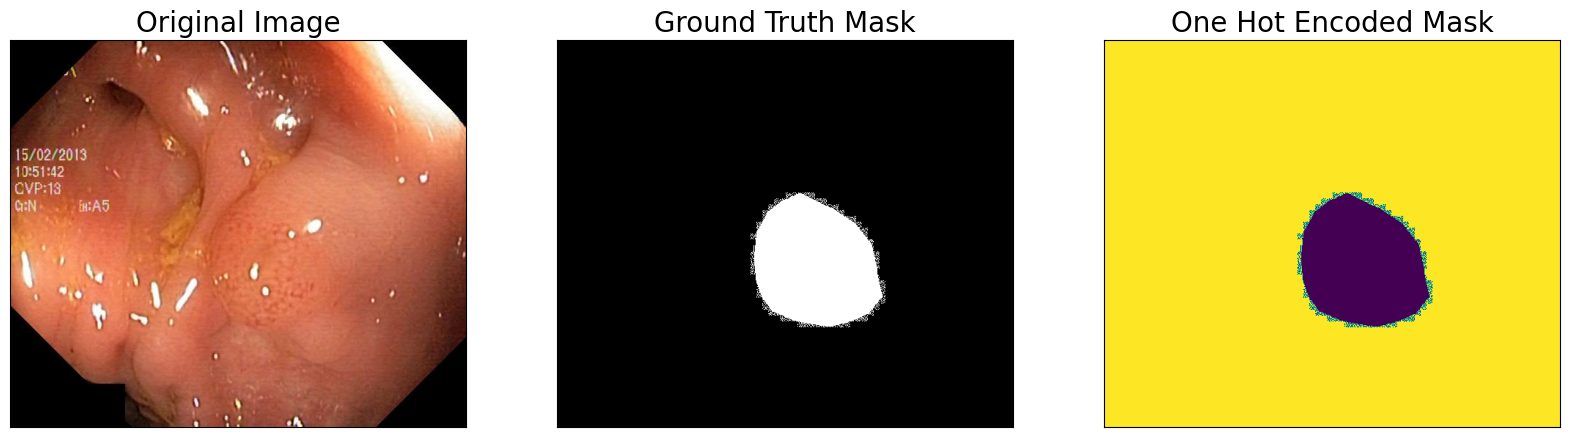

In [ ]:
# Load UNet Model
unet_model = torch.load('/content/unet_model.pth', map_location=DEVICE)

# create val dataloader to be used with UNet model
val_dataset_unet = Kvasir(
    val_data_df,
    augmentation=prepare_augmentations_for_validation(),
    preprocessing=prepare_preprocessing(preprocessing_fn),
    class_rgb_values=filtered_class_rgb,
)

val_dataloader_unet = DataLoader(val_dataset_unet)

# validation dataset for visualization
val_dataset_show = Kvasir(
    val_data_df,
    class_rgb_values=filtered_class_rgb,
)

# get a random test image/mask index
random_idx = random.randint(0, len(val_dataset_show)-1)
image, mask = val_dataset_show[random_idx]

show(
    original_image = image,
    ground_truth_mask = segmentation_color(reverse_one_hot(mask), filtered_class_rgb),
    one_hot_encoded_mask = reverse_one_hot(mask)
)


For each value within the range of the validation dataset length, the following steps are performed to visualize predictions:

- Retrieve the image and ground truth mask from the validation dataset.
- Prepare a visual representation of the original image from the separate visualization-oriented dataset, resizing it for consistent display.
- Convert the image to a tensor format and move it to the appropriate device.
- Utilize the pre-trained UNet model to predict a segmentation mask for the validation image.
- Convert the predicted mask from CHW to HWC format and extract the channel corresponding to the 'polyp' class.
- Generate color-coded visualizations for the ground truth and predicted masks, transforming them from one-hot encoded format.
- Display the original image along with the ground truth mask, predicted mask, and the heatmap representing the 'polyp' class prediction.

## Assessing UNet Model Performance on Validation Set

Using a dedicated evaluation process (test_epoch), the pre-trained model is assessed on the test dataset. The evaluation incorporates the defined loss function and metrics while utilizing the specified device for computations.

Upon execution, the evaluation achieves an IoU score of 0.8897 and a Dice loss of 0.0705 and Dice Score of 0.9374 on the test data. This demonstrates the model's segmentation performance and provides insight into its accuracy and effectiveness in segmenting the test dataset.

In [ ]:
test_epoch_unet = smp.utils.train.ValidEpoch(
    unet_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs_unet = test_epoch_unet.run(val_dataloader_unet)

print("Evaluation on Validation Data for UNet: ")
print(f"Mean IoU Score: {valid_logs_unet['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs_unet['dice_loss']:.4f}")
print(f"Mean Dice Score: {valid_logs_unet['fscore']:.4f}")

valid: 100%|██████████| 100/100 [00:08<00:00, 11.83it/s, dice_loss - 0.07053, iou_score - 0.8897, fscore - 0.9374]
Evaluation on Validation Data for UNet: 
Mean IoU Score: 0.8897
Mean Dice Loss: 0.0705
Mean Dice Score: 0.9374


In [ ]:
# Plot Dice Score & IoU Metric for Train vs. Val for UNet
train_logs_df_unet = pd.DataFrame(train_logs_list_Unet)
valid_logs_df_unet = pd.DataFrame(valid_logs_list_Unet)
train_logs_df_unet.T

,0,1,2,3,4
dice_loss,0.153295,0.098130,0.077641,0.065151,0.056876
iou_score,0.874588,0.895190,0.898244,0.905154,0.911858
fscore,0.932122,0.943563,0.945232,0.949217,0.952936


The UNet model demonstrates progressive improvement across epochs, evident in decreasing Dice Loss values from 0.1533 to 0.0569. This reduction underscores enhanced segmentation accuracy. Moreover, the IoU Score (Jaccard Index) consistently increases from 0.8746 to 0.9119, indicating improved overlap between predicted and ground truth masks. The Dice Score (F1 Score) follows a similar trend, rising from 0.9321 to 0.9529. These results highlight the UNet model's proficiency in accurate image segmentation and its potential for various applications.

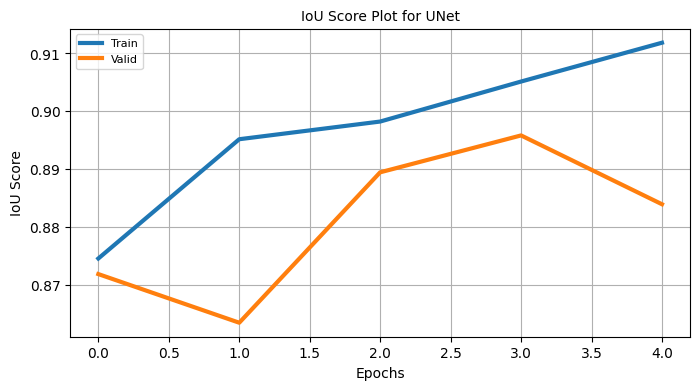

In [ ]:
# IoU Score Plot for UNet
plt.figure(figsize=(8,4))
plt.plot(train_logs_df_unet.index.tolist(), train_logs_df_unet.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df_unet.index.tolist(), valid_logs_df_unet.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('IoU Score', fontsize=10)
plt.title('IoU Score Plot for UNet', fontsize=10)
plt.legend(loc='best', fontsize=8)
plt.grid()
plt.show()

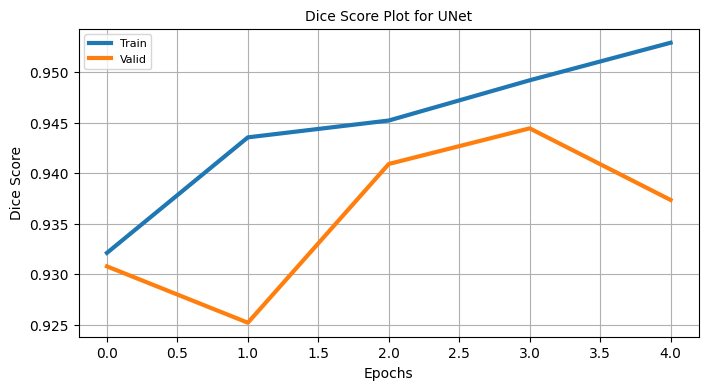

In [ ]:
# Dice Score Plot for UNet
plt.figure(figsize=(8,4))
plt.plot(train_logs_df_unet.index.tolist(), train_logs_df_unet.fscore.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df_unet.index.tolist(), valid_logs_df_unet.fscore.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Dice Score', fontsize=10)
plt.title('Dice Score Plot for UNet', fontsize=10)
plt.legend(loc='best', fontsize=8)
plt.grid()
plt.show()

# PSPNet Model

A segmentation model based on the PSPNet architecture is constructed using a pretrained encoder. The optimizer and learning rate scheduler are configured for the PSPNet model. Training and validation epochs are defined for the PSPNet model, incorporating the Dice Loss and specified metrics for evaluation. This setup facilitates the training and assessment of the PSPNet model's performance in image segmentation tasks.

In [ ]:
# create segmentation model with pretrained encoder
pspnet_model = smp.PSPNet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)


In [ ]:
# define optimizer pspnet
optimizer_pspnet = torch.optim.Adam([
    dict(params=pspnet_model.parameters(), lr=0.0001),
])
# define learning rate scheduler
lr_scheduler_pspnet = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_pspnet, T_0=1, T_mult=2, eta_min=5e-5,
)

# Train Set Epoch
train_epoch_pspnet = smp.utils.train.TrainEpoch(
    pspnet_model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer_pspnet,
    device=DEVICE,
    verbose=True,
)

# Valid Set Epoch
valid_epoch_pspnet = smp.utils.train.ValidEpoch(
    pspnet_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

Throughout the specified number of epochs, both training and validation processes are executed for the PSPNet model. Progress updates are displayed for each epoch. Training and validation logs are collected and stored separately for PSPNet. The PSPNet model is saved after each epoch. This process ensures iterative improvement and model preservation, contributing to the enhancement and retention of the PSPNet model's segmentation capabilities.

In [ ]:
train_logs_list_PSPnet, valid_logs_list_PSPnet = [], []
iou_score = 0.0

for i in range(0, EPOCHS):
    # Perform training & validation
    print('\nEpoch: {}'.format(i))
    train_logs_pspnet = train_epoch_pspnet.run(train_loader)
    valid_logs_pspnet = valid_epoch_pspnet.run(valid_loader)
    train_logs_list_PSPnet.append(train_logs_pspnet)
    valid_logs_list_PSPnet.append(valid_logs_pspnet)
    torch.save(pspnet_model, '/content/pspnet_model.pth')
    print('Model saved!')


Epoch: 0
valid: 100%|██████████| 25/25 [00:06<00:00,  3.62it/s, dice_loss - 0.1268, iou_score - 0.7893, fscore - 0.8804]
Model saved!

Epoch: 1
valid: 100%|██████████| 25/25 [00:05<00:00,  4.58it/s, dice_loss - 0.09736, iou_score - 0.8343, fscore - 0.9084]
Model saved!

Epoch: 2
valid: 100%|██████████| 25/25 [00:05<00:00,  4.30it/s, dice_loss - 0.1164, iou_score - 0.8063, fscore - 0.8907]
Model saved!

Epoch: 3
valid: 100%|██████████| 25/25 [00:06<00:00,  3.59it/s, dice_loss - 0.09118, iou_score - 0.8408, fscore - 0.9122]
Model saved!

Epoch: 4
valid: 100%|██████████| 25/25 [00:05<00:00,  4.52it/s, dice_loss - 0.08286, iou_score - 0.8553, fscore - 0.921]
Model saved!


## PSPNet Model Inference on Validation Set

Load a pre-trained PSPNet model from /content/pspnet_model.pth, adapting its location based on the device availability (DEVICE). A validation dataset is established, incorporating defined augmentations and preprocessing for validation purposes. A DataLoader is then created for the test dataset.

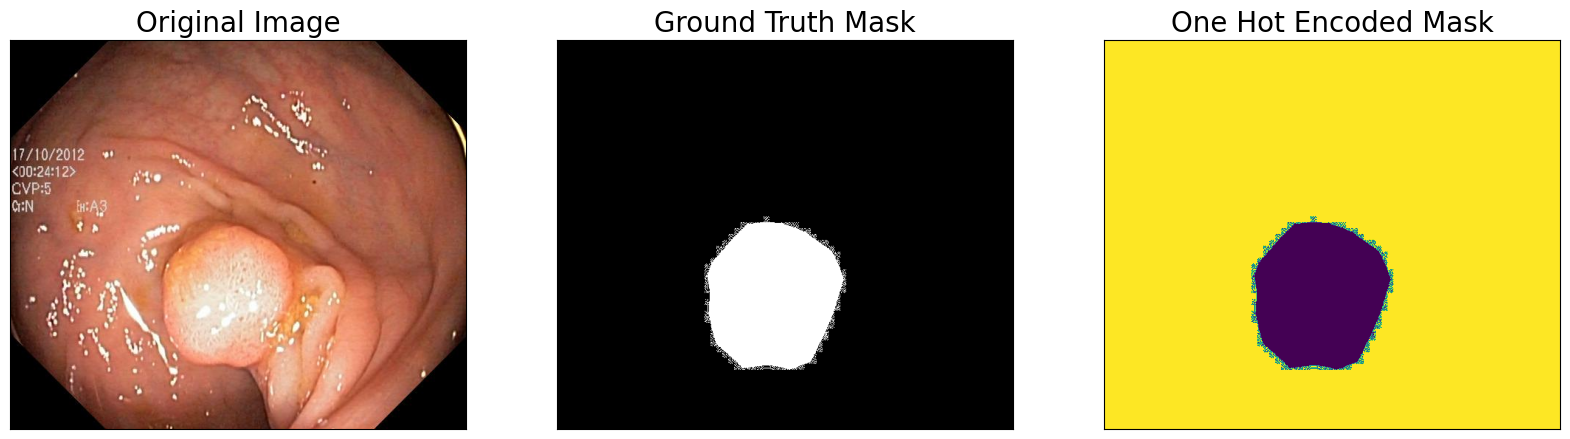

In [ ]:
# Load PSPNet Model
pspnet_model = torch.load('/content/pspnet_model.pth', map_location=DEVICE)

# create val dataloader to be used with PSPNet model
val_dataset_pspnet = Kvasir(
    val_data_df,
    augmentation=prepare_augmentations_for_validation(),
    preprocessing=prepare_preprocessing(preprocessing_fn),
    class_rgb_values=filtered_class_rgb,
)

val_dataloader_pspnet = DataLoader(val_dataset_pspnet)

# validation dataset for visualization
val_dataset_show = Kvasir(
    val_data_df,
    class_rgb_values=filtered_class_rgb,
)

# get a random test image/mask index
random_idx = random.randint(0, len(val_dataset_show)-1)
image, mask = val_dataset_show[random_idx]

show(
    original_image = image,
    ground_truth_mask = segmentation_color(reverse_one_hot(mask), filtered_class_rgb),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

For each value within the range of the validation dataset length for pspnet, the following steps are performed to visualize predictions:

- Retrieve the image and ground truth mask from the validation dataset.
- Prepare a visual representation of the original image from the separate visualization-oriented dataset, resizing it for consistent display.
- Convert the image to a tensor format and move it to the appropriate device.
- Utilize the pre-trained UNet model to predict a segmentation mask for the validation image.
- Convert the predicted mask from CHW to HWC format and extract the channel corresponding to the 'polyp' class.
- Generate color-coded visualizations for the ground truth and predicted masks, transforming them from one-hot encoded format.
- Display the original image along with the ground truth mask, predicted mask, and the heatmap representing the 'polyp' class prediction.

## Assessing PSPNet Model Performance on Validation Set

Using a dedicated evaluation process (test_epoch), the pre-trained model is assessed on the test dataset for pspnet. The evaluation incorporates the defined loss function and metrics while utilizing the specified device for computations.

Upon execution, the evaluation achieves an IoU score of 0.8600 and a Dice loss of 0.0828 and Dice Score of 0.9210 on the test data. This demonstrates the model's segmentation performance and provides insight into its accuracy and effectiveness in segmenting the test dataset.

In [ ]:
test_epoch_pspnet = smp.utils.train.ValidEpoch(
    pspnet_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs_pspnet = test_epoch_pspnet.run(val_dataloader_pspnet)

print("Evaluation on Validation Data for PSPNet: ")
print(f"Mean IoU Score: {valid_logs_pspnet['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs_pspnet['dice_loss']:.4f}")
print(f"Mean Dice Score: {valid_logs_pspnet['fscore']:.4f}")

valid: 100%|██████████| 100/100 [00:08<00:00, 12.19it/s, dice_loss - 0.08278, iou_score - 0.86, fscore - 0.921]
Evaluation on Validation Data for PSPNet: 
Mean IoU Score: 0.8600
Mean Dice Loss: 0.0828
Mean Dice Score: 0.9210


In [ ]:
# Plot Dice Score & IoU Metric for Train vs. Val for PSPNet
train_logs_df_pspnet = pd.DataFrame(train_logs_list_PSPnet)
valid_logs_df_pspnet = pd.DataFrame(valid_logs_list_PSPnet)
train_logs_df_pspnet.T

,0,1,2,3,4
dice_loss,0.156990,0.105502,0.092216,0.085852,0.079802
iou_score,0.756549,0.822493,0.842161,0.851748,0.860717
fscore,0.854204,0.900609,0.912532,0.918100,0.923667


The PSPNet model exhibits gradual enhancement across epochs, reflected in the declining Dice Loss values from 0.1570 to 0.0798. This reduction underscores improved segmentation precision. The IoU Score (Jaccard Index) steadily increases from 0.7565 to 0.8607, indicating augmented overlap between predicted and ground truth masks. The Dice Score (F1 Score) also follows an upward trend, elevating from 0.8542 to 0.9237. These outcomes highlight PSPNet's effectiveness in precise image segmentation, suggesting its potential for diverse applications.

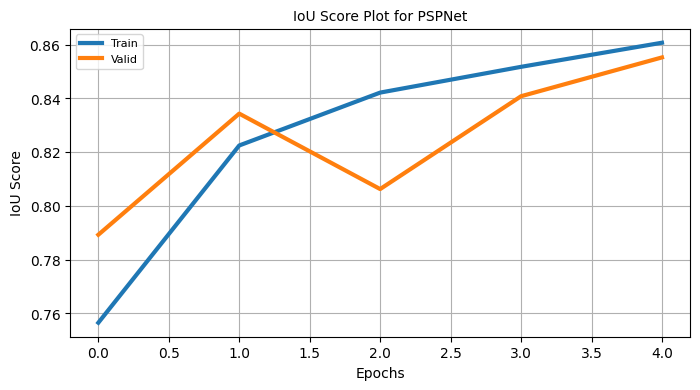

In [ ]:
# IoU Score Plot for PSPNet
plt.figure(figsize=(8,4))
plt.plot(train_logs_df_pspnet.index.tolist(), train_logs_df_pspnet.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df_pspnet.index.tolist(), valid_logs_df_pspnet.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('IoU Score', fontsize=10)
plt.title('IoU Score Plot for PSPNet', fontsize=10)
plt.legend(loc='best', fontsize=8)
plt.grid()
plt.show()

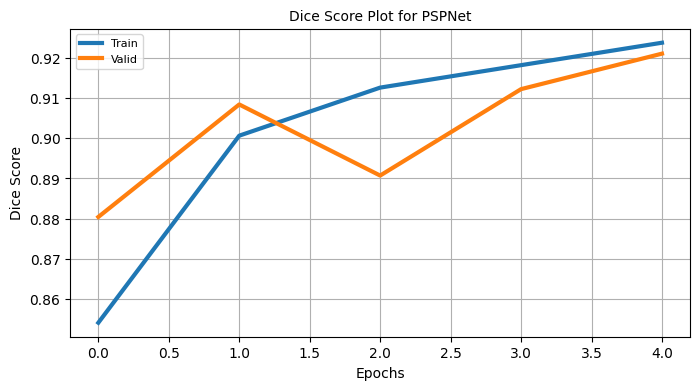

In [ ]:
# Dice Score Plot for PSPNet
plt.figure(figsize=(8,4))
plt.plot(train_logs_df_pspnet.index.tolist(), train_logs_df_pspnet.fscore.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df_pspnet.index.tolist(), valid_logs_df_pspnet.fscore.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Dice Score', fontsize=10)
plt.title('Dice Score Plot for PSPNet', fontsize=10)
plt.legend(loc='best', fontsize=8)
plt.grid()
plt.show()

# Conclusion

The evaluation of the "Polyp Segmentation Model using UNet and PSPNet" project's outcomes reveals substantial insights into the segmentation capabilities of both UNet and PSPNet architectures.

For the UNet model, the evaluation on the validation dataset demonstrates good performance. The Mean IoU Score of 0.8897 signifies a strong overlap between predicted and ground truth masks, while the Mean Dice Loss of 0.0705 indicates precise segmentation accuracy. Additionally, the Mean Dice Score of 0.9374 underscores the model's proficiency in capturing polyp regions.

Similarly, the evaluation of the PSPNet model on the validation dataset reveals its competitive segmentation performance. The Mean IoU Score of 0.8600 showcases substantial overlap, although slightly lower than UNet. The Mean Dice Loss of 0.0828 indicates effective segmentation accuracy, while the Mean Dice Score of 0.9210 illustrates the PSPNet's ability to identify polyp regions with confidence.

In conclusion, both UNet and PSPNet models exhibit strong segmentation capabilities, with UNet slightly outperforming PSPNet in terms of IoU score and Dice Score. This project's systematic approach to data preparation, model training, and evaluation underscores the significance of tailored architecture selection and good training processes. The comprehensive pipeline developed throughout this project contributes substantially to the advancement of polyp segmentation methodologies, fostering accurate polyp detection and diagnosis in the realm of medical imaging applications.

# References

- Jha, D., Smedsrud, P. H., Riegler, M. A., Halvorsen, P., de Lange, T., Johansen, D., & Johansen, H. D. (2020). Kvasir-seg: A segmented polyp dataset. In International Conference on Multimedia Modeling (pp. 451-462). Springer.

- Qiu, Z., Wang, Z., Zhang, M., Xu, Z., Fan, J., & Xu, L. (2022, April). BDG-Net: Boundary distribution guided network for accurate polyp segmentation. In Ivana Išgum & Olivier Colliot (Eds.), Medical Imaging 2022: Image Processing. {SPIE}. doi:10.1117/12.2606785

- Xiangxiang Chu, Zhi Tian, Bo Zhang, Xinlong Wang, Xiaolin Wei, Huaxia Xia, and Chunhua Shen. Conditional positional encodings for vision transformers. arXiv preprint arXiv:2102.10882, 2021.

- Alexey Dosovitskiy, Lucas Beyer, Alexander Kolesnikov, Dirk Weissenborn, Xiaohua Zhai, Thomas Unterthiner, Mostafa Dehghani, Matthias Minderer, Georg Heigold, Sylvain Gelly, et al. An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929, 2020.